In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import pywt
import noisereduce as nr
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\gabry\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Parameters
SAMPLE_RATE = 16000
N_MFCC = 13
N_MELS = 22
WINDOW = int(SAMPLE_RATE * 0.01)
HOP = int(SAMPLE_RATE * 0.005)
max_len = 671 

In [3]:
# Classes
labels = ['baca', 'berhenti', 'foto', 'halo', 'info', 'kembali', 'ulang']

In [4]:
# Load model
model = load_model('model/mymodelg.h5')

In [5]:
# Fungsi preprocessing dan ekstraksi fitur
def load_audio(file_path, sr=SAMPLE_RATE):
    audio, _ = librosa.load(file_path, sr=sr)
    return audio / np.max(np.abs(audio))

def reduce_noise(audio):
    return nr.reduce_noise(y=audio, sr=SAMPLE_RATE)

def preprocess_audio(file_path):
    audio = load_audio(file_path)
    return reduce_noise(audio)

def wavelet_transform(signal):
    wp = pywt.WaveletPacket(signal, wavelet='db4', mode='symmetric', maxlevel=3)
    return np.concatenate([n.data for n in wp.get_level(3, 'freq')])

def extract_mfcc(signal):
    return librosa.feature.mfcc(
        y=wavelet_transform(signal),
        sr=SAMPLE_RATE,
        n_mfcc=N_MFCC,
        n_mels=N_MELS,
        n_fft=WINDOW,
        hop_length=HOP
    ).T

In [ ]:
# Inisialisasi
y_true, y_pred = [], []
dataset_path = 'datasetuji'
# max_len = None

In [9]:
# Lakukan prediksi
for label in labels:
    folder_path = os.path.join(dataset_path, label)
    for filename in os.listdir(folder_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(folder_path, filename)
            signal = preprocess_audio(file_path)
            mfcc = extract_mfcc(signal)

            # Padding agar sama panjang
            x_input = pad_sequences([mfcc], maxlen=max_len, padding='post', dtype='float32')

            prediction = model.predict(x_input)
            pred_label_idx = np.argmax(prediction)

            y_true.append(labels.index(label))
            y_pred.append(pred_label_idx)

1/1 [==============================] - 0s 115ms/step


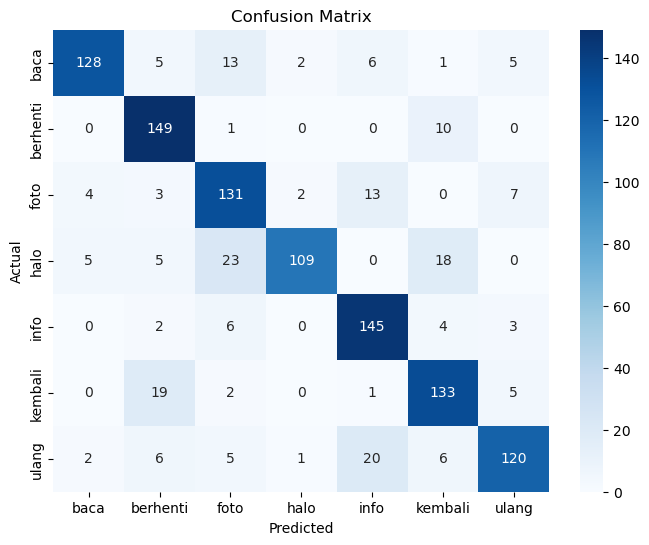

              precision    recall  f1-score   support

        baca       0.92      0.80      0.86       160
    berhenti       0.79      0.93      0.85       160
        foto       0.72      0.82      0.77       160
        halo       0.96      0.68      0.80       160
        info       0.78      0.91      0.84       160
     kembali       0.77      0.83      0.80       160
       ulang       0.86      0.75      0.80       160

    accuracy                           0.82      1120
   macro avg       0.83      0.82      0.82      1120
weighted avg       0.83      0.82      0.82      1120



In [10]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=labels)
print(report)

C:\Users\gabry\AppData\Local\Temp\ipykernel_18184\3223405892.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracy_per_label, palette='viridis')


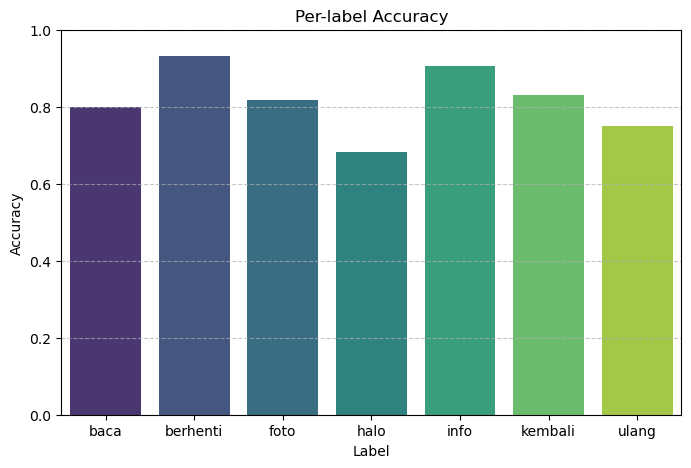

In [11]:
# Akurasi per Label
correct_per_label = np.diag(cm) 
total_per_label = np.sum(cm, axis=1)
accuracy_per_label = correct_per_label / total_per_label

# Bar Chart Akurasi per Label
plt.figure(figsize=(8, 5))
sns.barplot(x=labels, y=accuracy_per_label, palette='viridis')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.xlabel('Label')
plt.title('Per-label Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
